# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import os
import random
import parmap
from functools import partial

import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/input/data' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [3]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

In [4]:
df = feature_engineering(df)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.947683,1268,0.913187,3040


## 3. Train/Test 데이터 셋 분리

In [5]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.9, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [6]:
cate= ['KnowledgeTag', 'testId','assessmentItemID']
for c in cate:
    df[c] = df[c].astype('category')

In [49]:
def past_testid_maker(df_in,num = 1):
    #유저 testid group 전처리
    df_in.groupby(['userID'])['testId'].unique()
    userIDs = df_in['userID'].unique()
    gp_uniq_u_tID = df_in.groupby(['userID'])['testId'].unique()
    grouped = df_in.groupby(['userID','testId'])
    
    # 실제 연산
    num = 5 # testId = shift 수
    for i in range(1,num+1):
        list_of_df = [] = [] # concat으로 모으는 df
        for user in tqdm(userIDs):
            unq_testid_by_user = gp_uniq_u_tID[user] # 유저별 testid 배열 
            for j in range(len(unq_testid_by_user)):
                if j-i < 0:
                    temp = grouped.get_group((user,unq_testid_by_user[j])).copy()
                    temp[f'past_testid_{i}'] = -1
                else:
                    temp = grouped.get_group((user,unq_testid_by_user[j])).copy()
                    temp[f'past_testid_{i}'] = unq_testid_by_user[j-i]
                list_of_df.append(temp)
        df_cat = pd.concat(list_of_df)
        df_in[f'past_testid_{i}'] = df_cat[f'past_testid_{i}']
    return df_in

In [ ]:
df = past_testid_maker(df,5)


100%|██████████| 6698/6698 [03:15<00:00, 34.34it/s] 


In [31]:
cate= ['KnowledgeTag', 'testId','assessmentItemID','past_testid_1']
for c in cate:
    df[c] = df[c].astype('category')

# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']
FEATS = ['KnowledgeTag','testId','assessmentItemID', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum','past_testid_1']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [ ]:
# !pip install lightgbm

In [32]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [33]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685 entries, 8498 to 2266529
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   userID               685 non-null    int64   
 1   assessmentItemID     685 non-null    category
 2   testId               685 non-null    category
 3   Timestamp            685 non-null    object  
 4   KnowledgeTag         685 non-null    category
 5   user_correct_answer  685 non-null    float64 
 6   user_total_answer    685 non-null    int64   
 7   user_acc             685 non-null    float64 
 8   test_mean            685 non-null    float64 
 9   test_sum             685 non-null    int64   
 10  tag_mean             685 non-null    float64 
 11  tag_sum              685 non-null    int64   
 12  past_testid_1        685 non-null    category
dtypes: category(4), float64(4), int64(4), object(1)
memory usage: 518.8+ KB


## 4. 훈련 및 검증

In [48]:
model = lgb.train(
    {'objective': 'binary',
     'metric': 'auc',
     'learning_rate': 0.1,
     'max_depth':8,
     'boosting': 'gbdt',
     'num_leaves':64,
     'seed':0,
     }, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=3000,
    early_stopping_rounds=200
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1338089, number of negative: 701739
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14491
[LightGBM] [Info] Number of data points in the train set: 2039828, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655981 -> initscore=0.645436
[LightGBM] [Info] Start training from score 0.645436
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.791757	valid_1's auc: 0.742189
[200]	training's auc: 0.804136	valid_1's auc: 0.748501
[300]	training's auc: 0.812322	valid_1's auc: 0.751165
[400]	training's auc: 0.819162	valid_1's auc: 0.751846
[500]	training's auc: 0.825477	valid_1's auc: 0.752437
[600]	training's auc: 0.831555	valid_1's auc: 0.751734
[700]	training's auc: 0.837664	valid_1's au

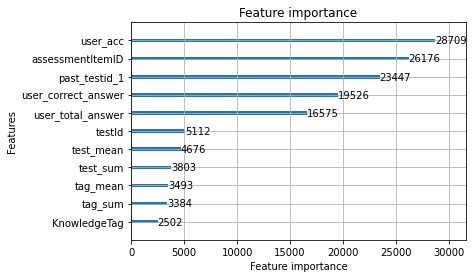

In [37]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [38]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [ ]:
test_df = past_testid_maker(test_df,5)

In [45]:
cate= ['KnowledgeTag', 'testId','assessmentItemID','past_testid_1']
for c in cate:
    test_df[c] = test_df[c].astype('category')

In [46]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [47]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/submission.csv
